In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 불러오기
path_1_train = "/Users/jeongseohyeon/Desktop/AnomalyDiT-main/Dataset/NonInvasiveFetalECGThorax1_TRAIN.tsv"
path_1_test = "/Users/jeongseohyeon/Desktop/AnomalyDiT-main/Dataset/NonInvasiveFetalECGThorax1_TEST.tsv"
path_2_train = "/Users/jeongseohyeon/Desktop/AnomalyDiT-main/Dataset/NonInvasiveFetalECGThorax2_TRAIN.tsv"
path_2_test = "/Users/jeongseohyeon/Desktop/AnomalyDiT-main/Dataset/NonInvasiveFetalECGThorax2_TEST.tsv"

df1_train = pd.read_csv(path_1_train, sep="\t", header=None)
df1_test = pd.read_csv(path_1_test, sep="\t", header=None)
df2_train = pd.read_csv(path_2_train, sep="\t", header=None)
df2_test = pd.read_csv(path_2_test, sep="\t", header=None)

In [2]:
# train/test 분할 규칙에 따라 분리 (train: TRAIN 전체 + TEST의 클래스 1~32 / test: TEST의 클래스 33~42)
train_df1 = pd.concat([
    df1_train,
    df1_test[df1_test[0].isin(range(1, 33))]
], ignore_index=True)

train_df2 = pd.concat([
    df2_train,
    df2_test[df2_test[0].isin(range(1, 33))]
], ignore_index=True)

test_df1 = df1_test[df1_test[0].isin(range(33, 43))].reset_index(drop=True)
test_df2 = df2_test[df2_test[0].isin(range(33, 43))].reset_index(drop=True)

In [3]:
print(sorted(train_df1[0].unique()))
print("train_df1 (좌측) 클래스 수:", len(train_df1[0].unique()))

print(sorted(train_df2[0].unique()))
print("train_df2 (우측) 클래스 수:", len(train_df2[0].unique()))

print(sorted(test_df1[0].unique()))
print("test_df1 (좌측) 클래스 수:", len(test_df1[0].unique()))

print(sorted(test_df2[0].unique()))
print("test_df2 (우측) 클래스 수:", len(test_df2[0].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
train_df1 (좌측) 클래스 수: 42
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
train_df2 (우측) 클래스 수: 42
[33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
test_df1 (좌측) 클래스 수: 10
[33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
test_df2 (우측) 클래스 수: 10


In [4]:
# Multivariate 시계열 데이터로 변환 (B, 2, 750)
def make_multivariate_tensor(df1, df2):
    labels = df1.iloc[:, 0].values
    data1 = df1.iloc[:, 1:].values
    data2 = df2.iloc[:, 1:].values
    combined = np.stack([data1, data2], axis=1)  # (B, 2, 750)
    return labels, combined

train_labels, train_data = make_multivariate_tensor(train_df1, train_df2)
test_labels, test_data = make_multivariate_tensor(test_df1, test_df2)

# 데이터 shape 확인
print("✅ train_data shape:", train_data.shape)  # (3280, 2, 750)
print("✅ test_data shape:", test_data.shape)    # (485, 2, 750)

✅ train_data shape: (3280, 2, 750)
✅ test_data shape: (485, 2, 750)


In [5]:
print(sorted(np.unique(train_labels)))
print("train 클래스 수:", len(np.unique(train_labels)))

print(sorted(np.unique(test_labels)))
print("test 클래스 수:", len(np.unique(test_labels)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
train 클래스 수: 42
[33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
test 클래스 수: 10


In [6]:
# 클래스별 시계열 예시 시각화
def plot_multivariate_examples(labels, data, num_classes):
    unique_labels = sorted(set(labels))
    selected_labels = unique_labels[:num_classes]

    plt.figure(figsize=(15, 2.5 * num_classes))

    for i, label in enumerate(selected_labels):
        idx = np.where(labels == label)[0][0]
        series = data[idx]  # (2, 750)

        plt.subplot(num_classes, 1, i + 1)
        plt.plot(series[0], label='Thorax1', alpha=0.7)
        plt.plot(series[1], label='Thorax2', alpha=0.7)
        plt.title(f"Class {label} - Multivariate Signal")
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

#### train 데이터 (42개 클래스)

In [7]:
plot_multivariate_examples(train_labels, train_data, num_classes=42)

#### test 데이터 (10개 클래스)

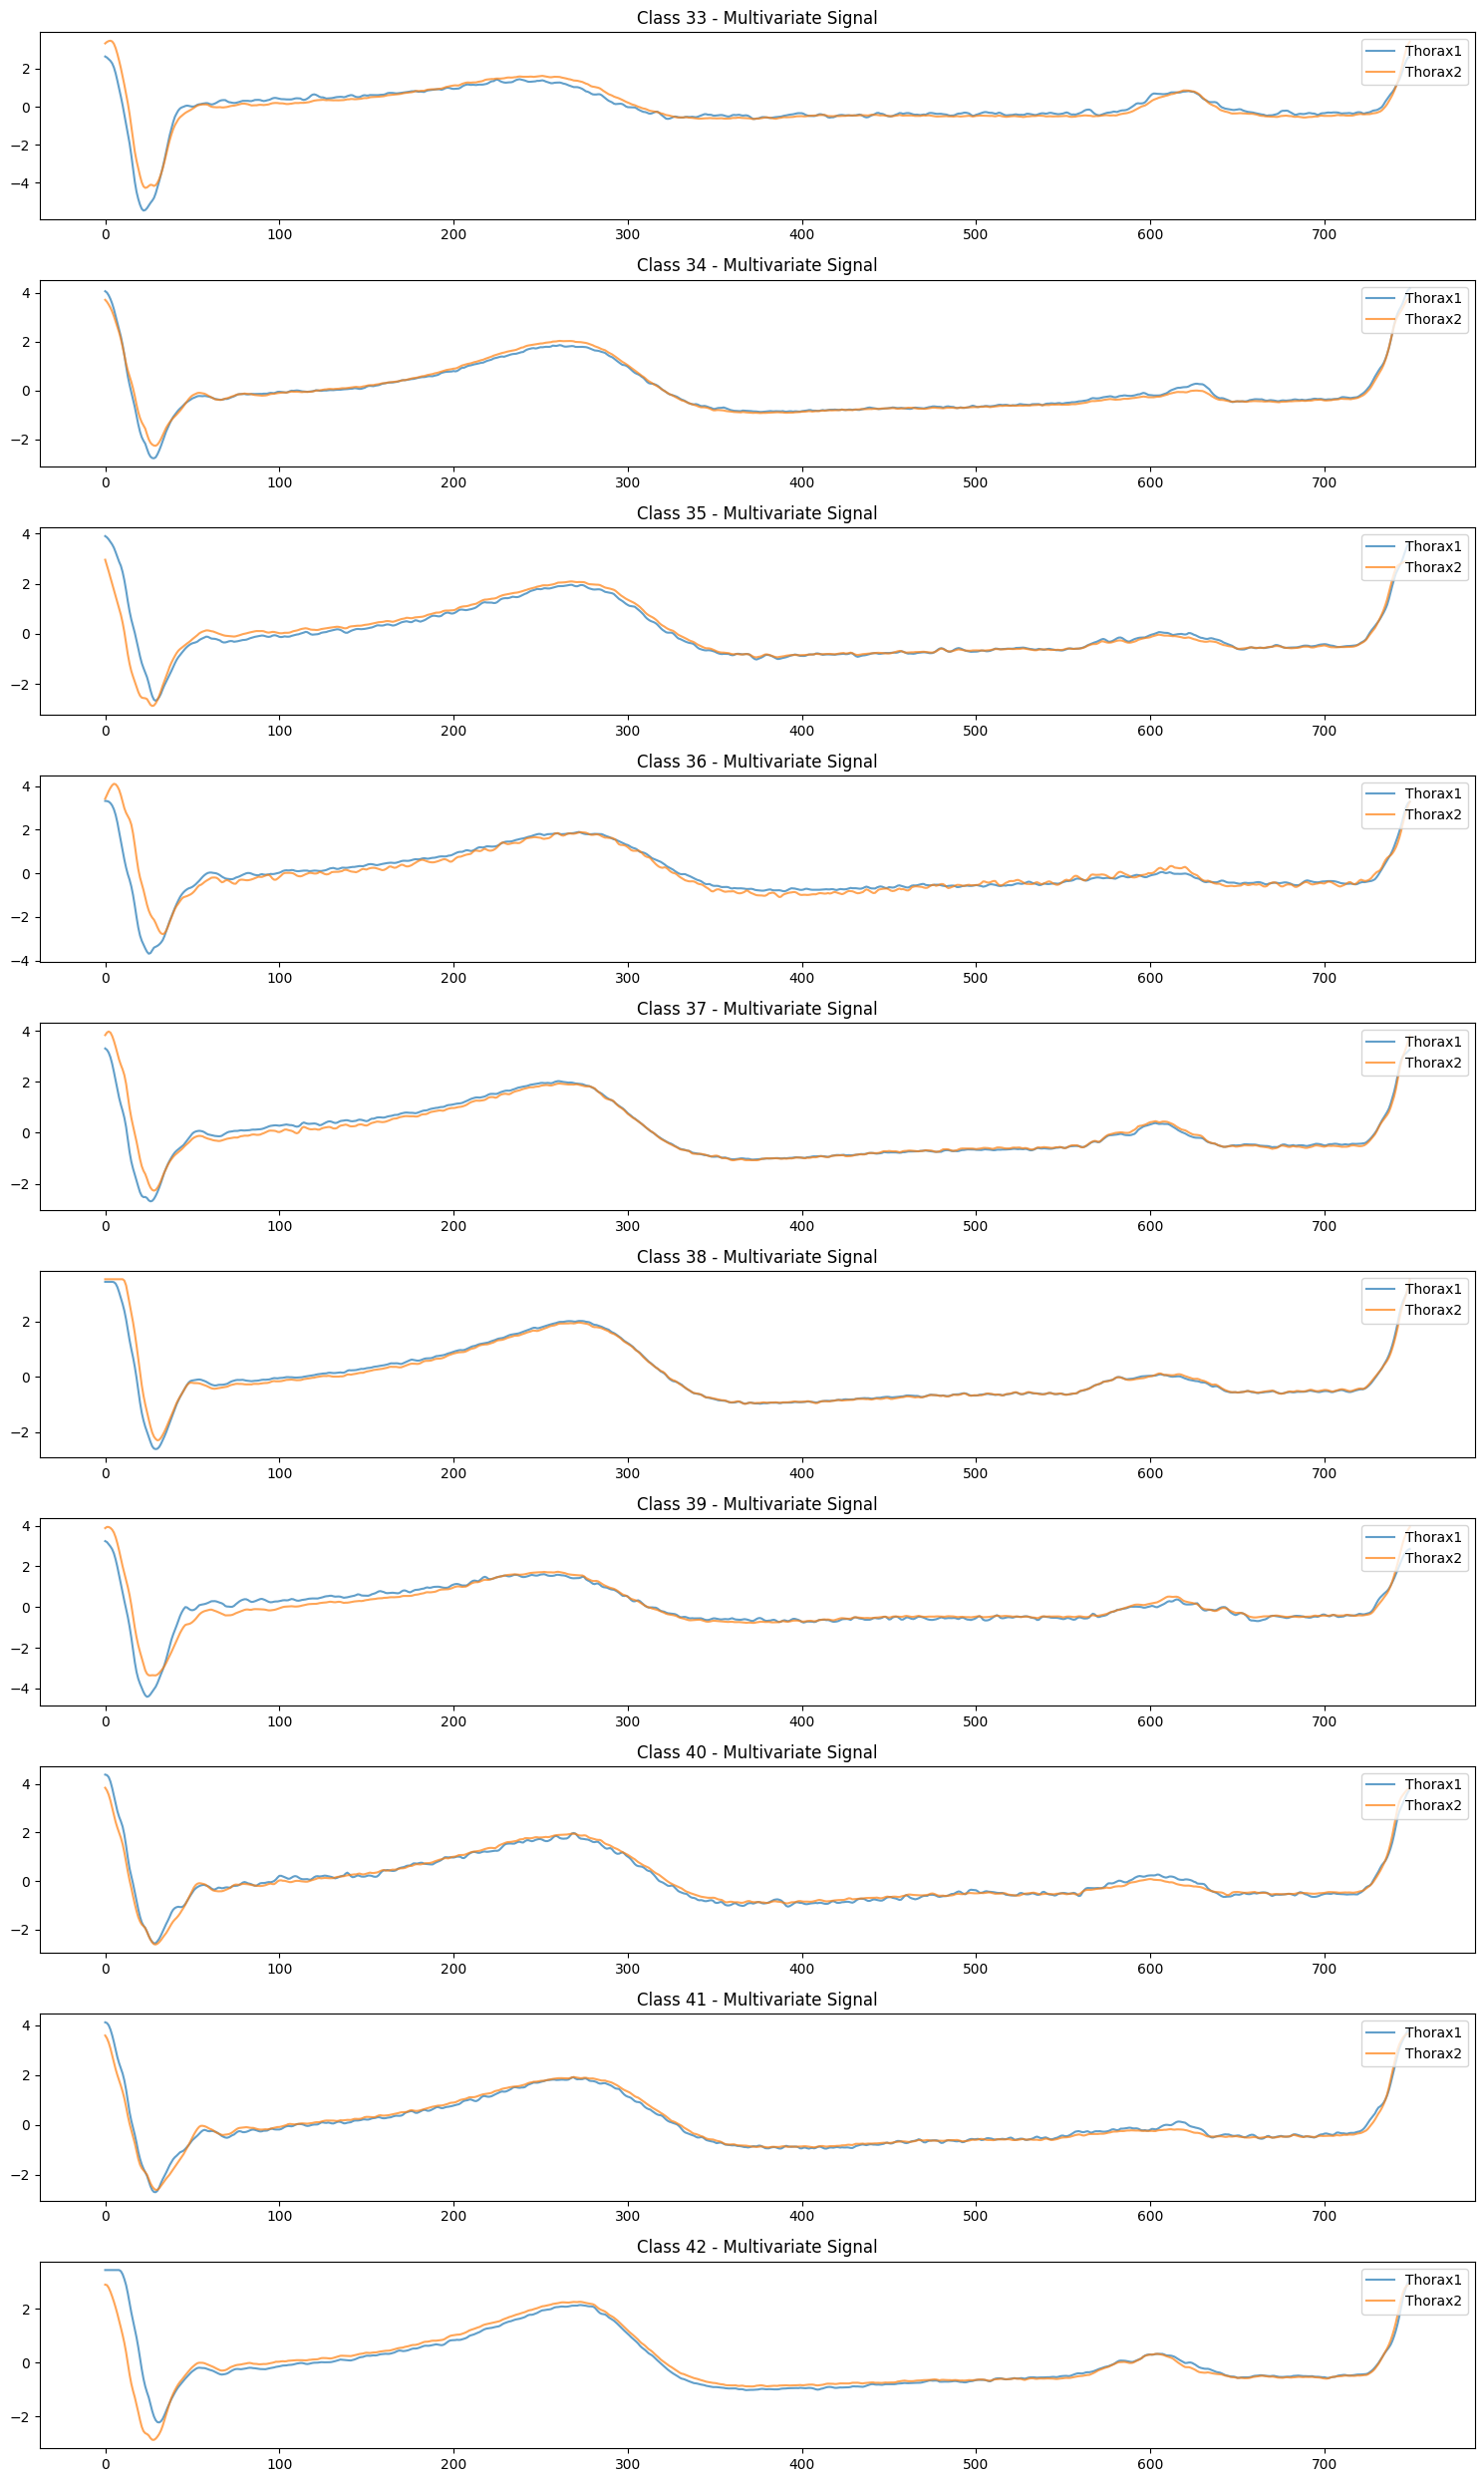

In [8]:
plot_multivariate_examples(test_labels, test_data, num_classes=10)

In [9]:
# 시계열 이상 삽입 함수
def inject_anomalies(data, labels, mode="noise", severity="small", window_size=50):
    """
    data: (B, 2, 750)
    labels: (B,)
    mode: "noise", "shift", "both"
    severity: "small", "medium", "large"
    window_size: 이상 삽입 시점 길이
    """
    severity_dict = {
        "small": 0.2,
        "medium": 0.5,
        "large": 1.0
    }

    anomaly_data = data.copy()
    anomaly_labels = np.zeros_like(data[:, 0, :])  # (B, 750)

    B, C, T = data.shape
    noise_level = severity_dict.get(severity, 0.2)
    shift_magnitude = severity_dict.get(severity, 0.2)

    for i in range(B):
        start = np.random.randint(100, T - window_size - 1)
        end = start + window_size

        if mode in ["noise", "both"]:
            noise = np.random.normal(loc=0.0, scale=noise_level, size=(C, window_size))
            anomaly_data[i, :, start:end] += noise

        if mode in ["shift", "both"]:
            shift = np.ones((C, window_size)) * shift_magnitude
            anomaly_data[i, :, start:end] += shift

        anomaly_labels[i, start:end] = 1  # 이상 삽입 위치 기록

    return anomaly_data, anomaly_labels

In [10]:
# 9가지 조건에 따라 이상 삽입
modes = ["noise", "shift", "both"]
severities = ["small", "medium", "large"]
results = {}

for mode in modes:
    for severity in severities:
        key = f"{mode}_{severity}"
        modified_data, anomaly_mask = inject_anomalies(test_data, test_labels, mode=mode, severity=severity)
        results[key] = {
            "data": modified_data,
            "anomaly_mask": anomaly_mask
        }

🔍 Condition: noise_small


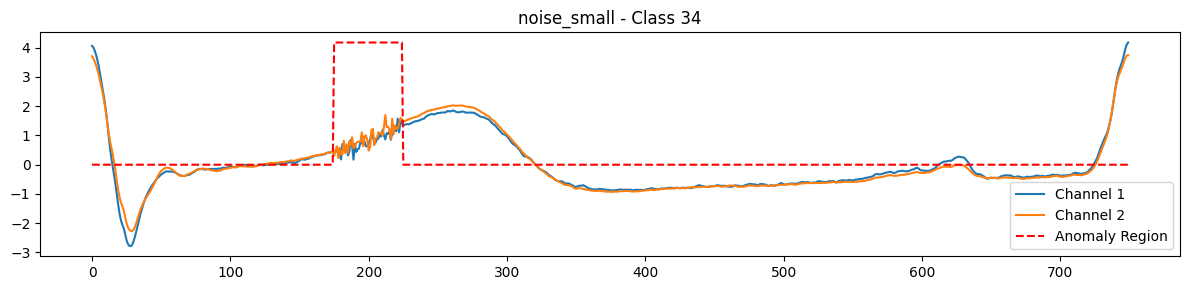

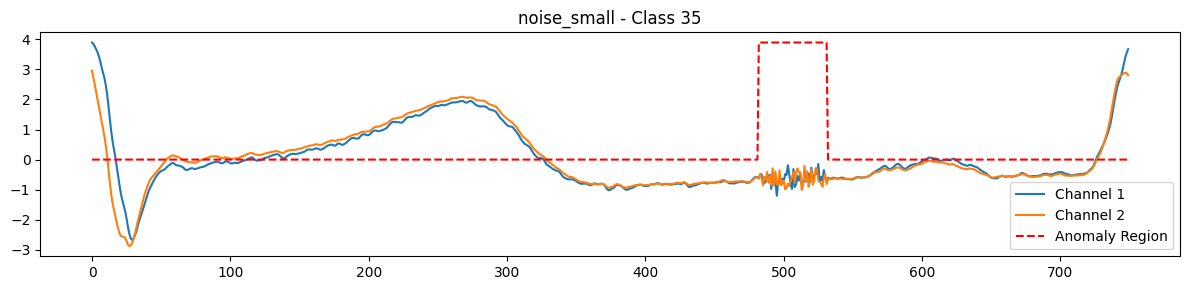

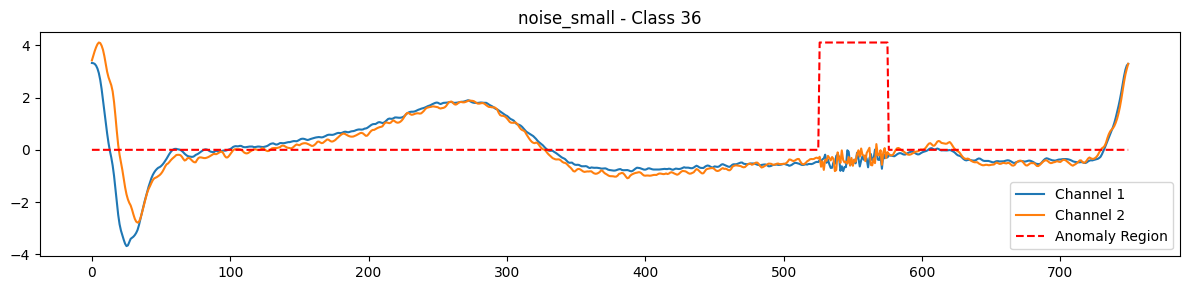

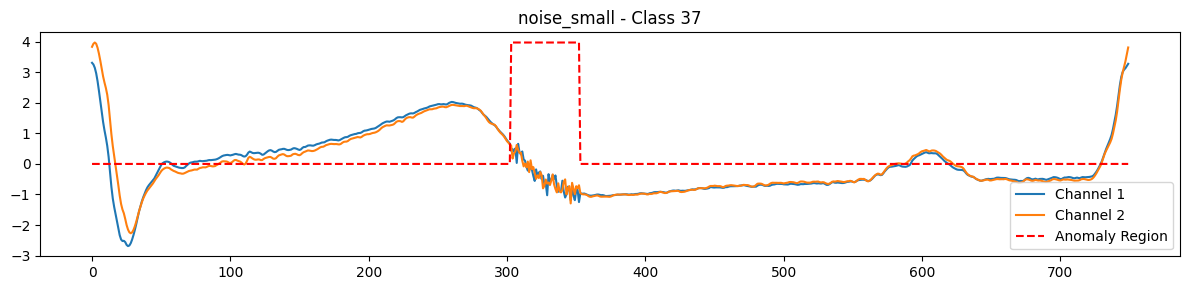

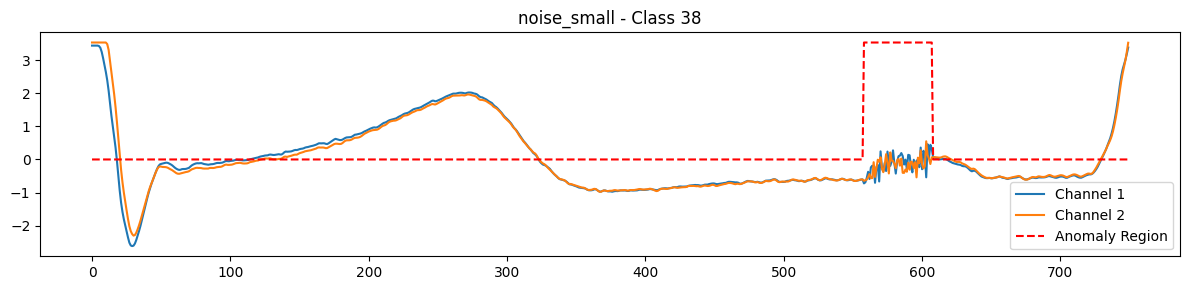

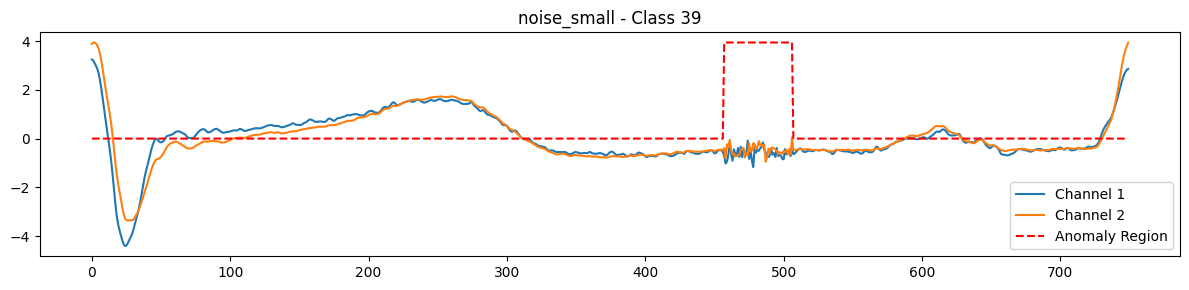

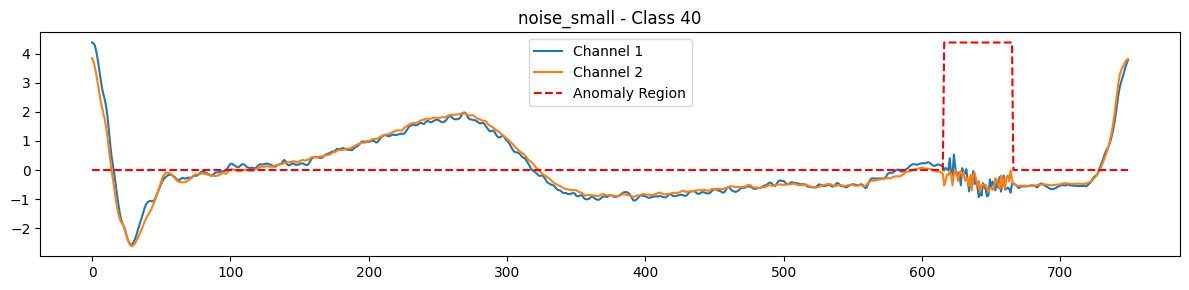

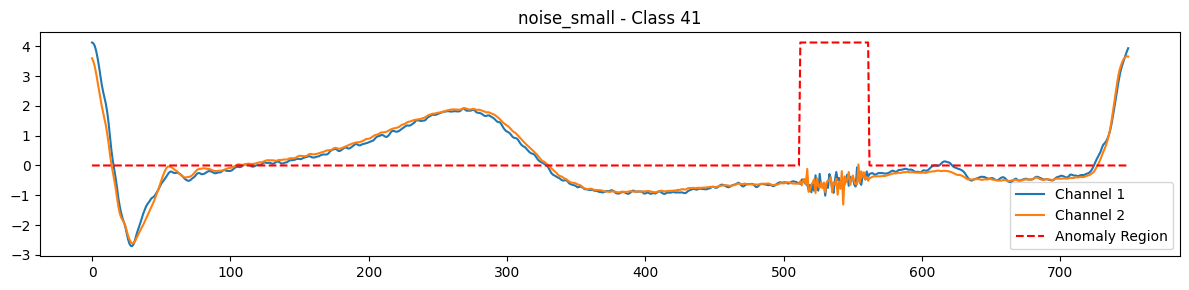

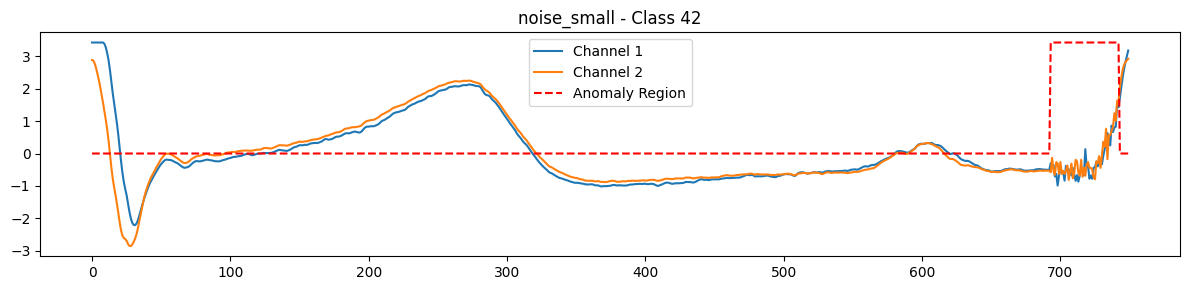

🔍 Condition: noise_medium


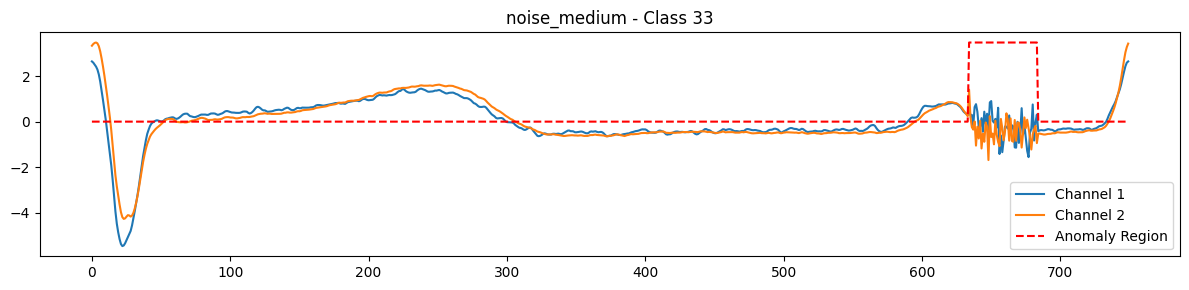

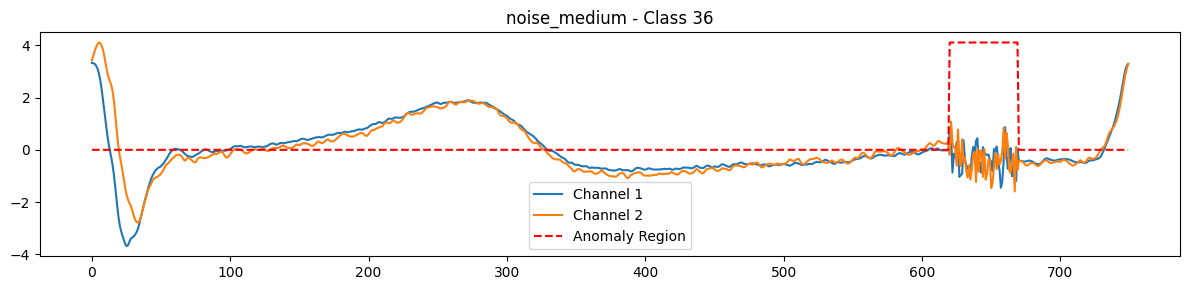

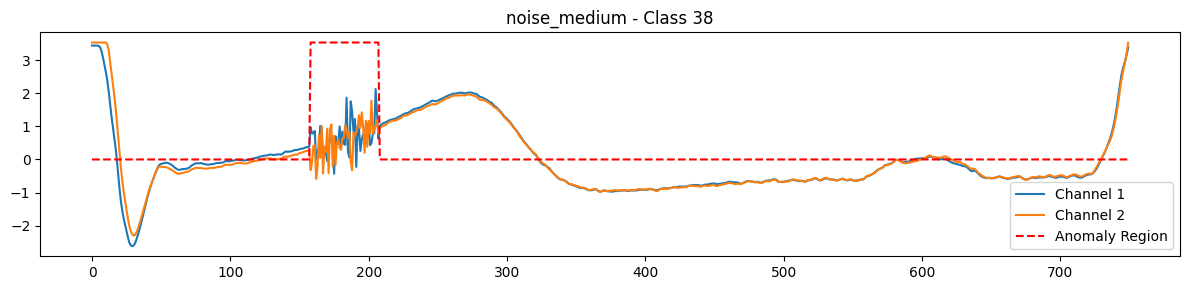

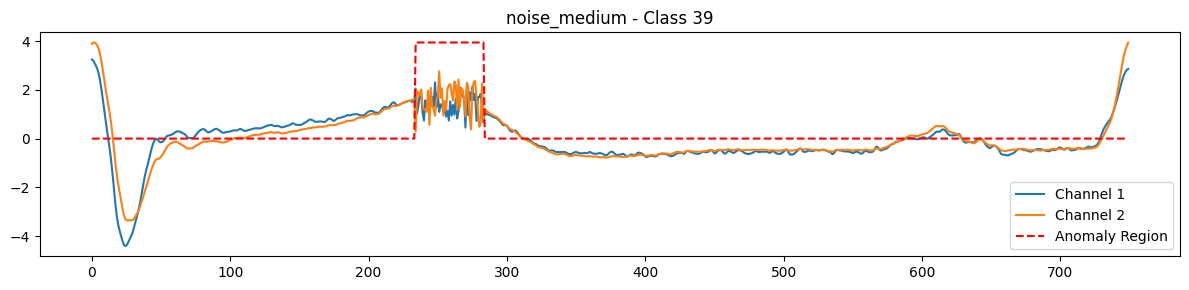

🔍 Condition: noise_large


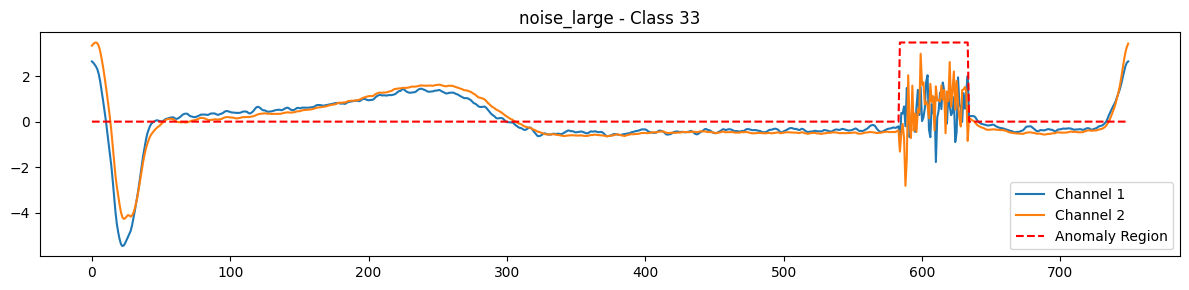

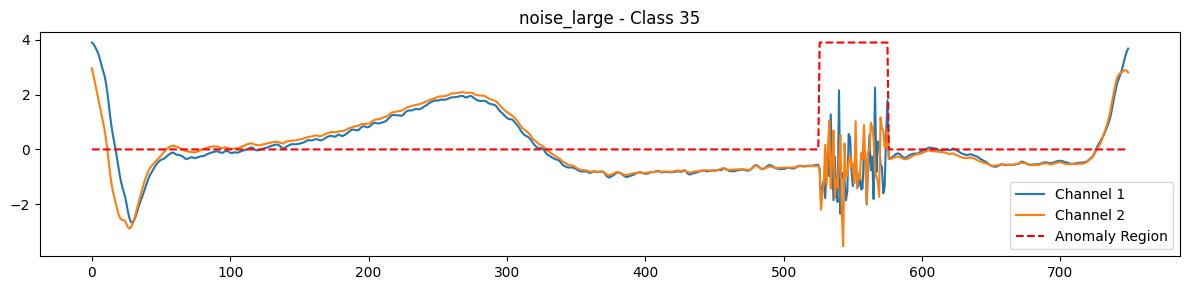

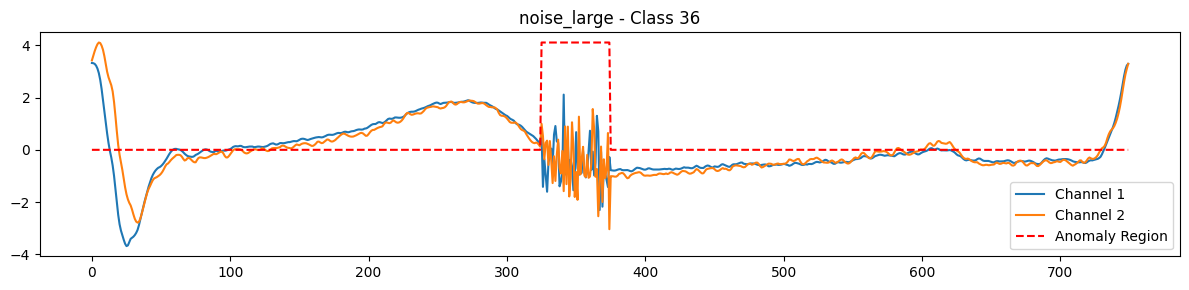

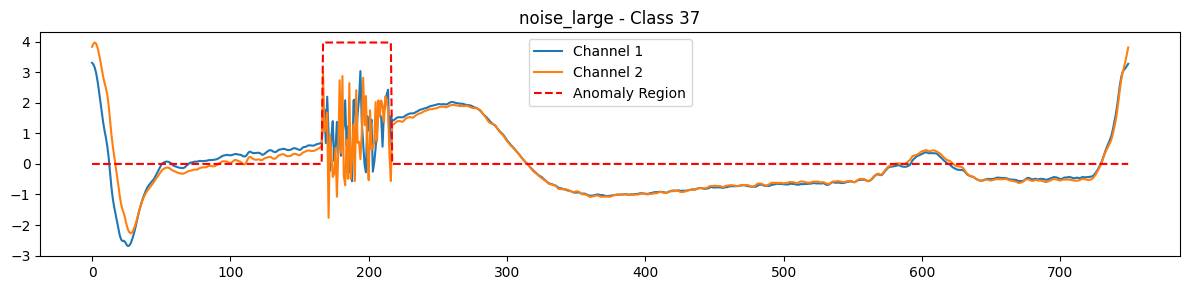

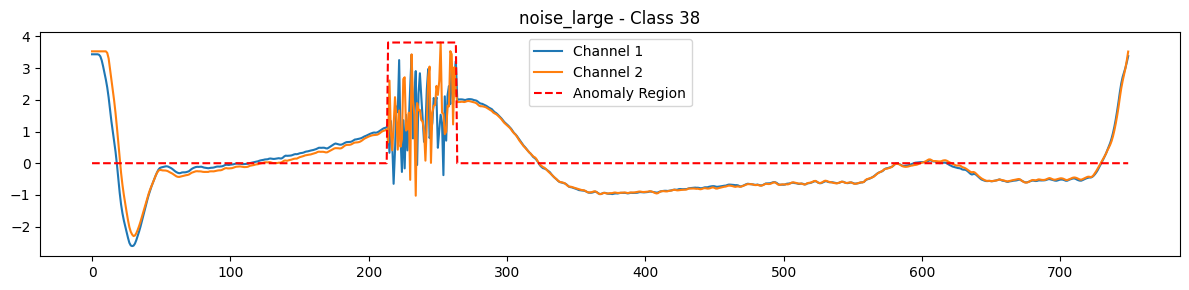

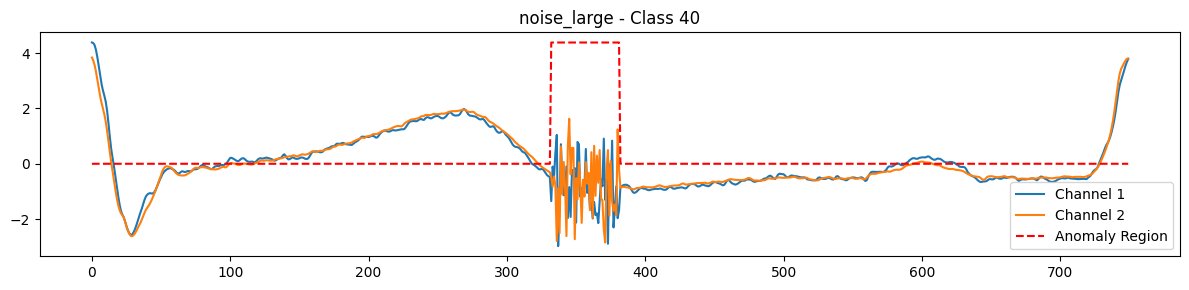

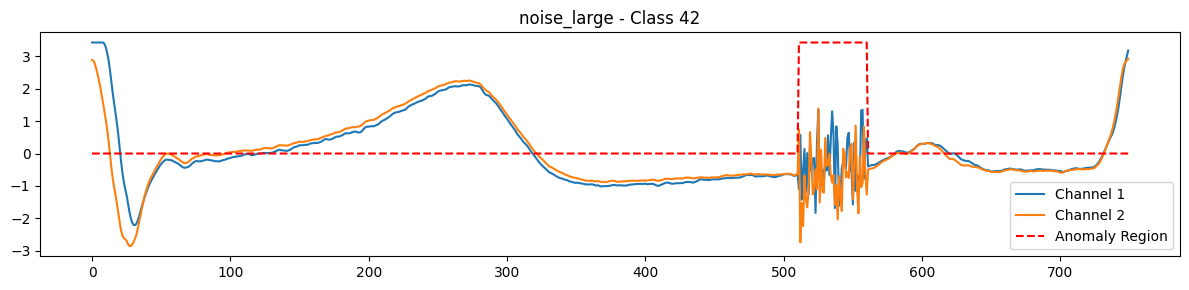

🔍 Condition: shift_small


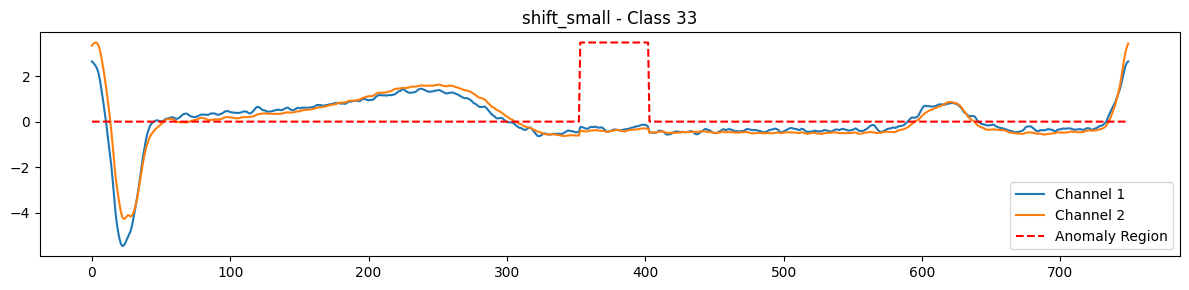

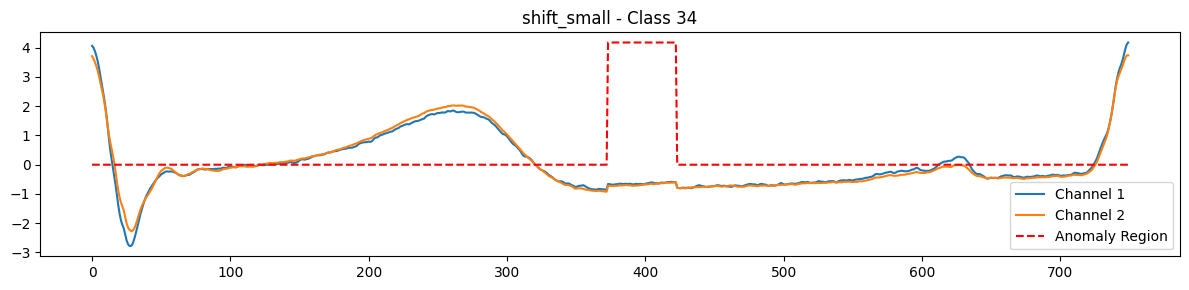

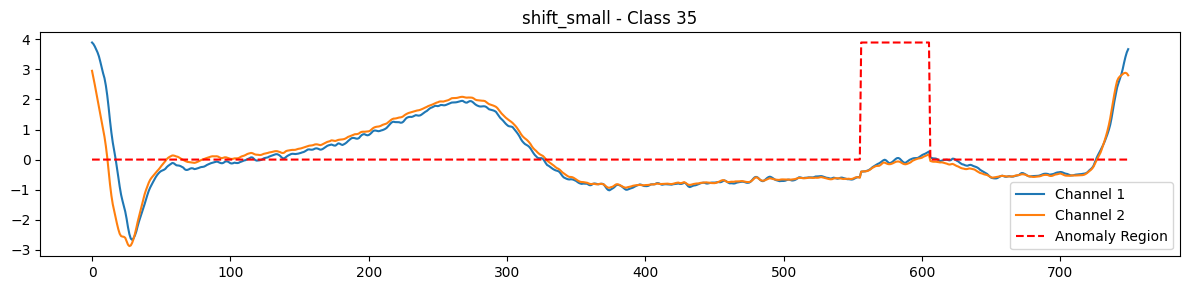

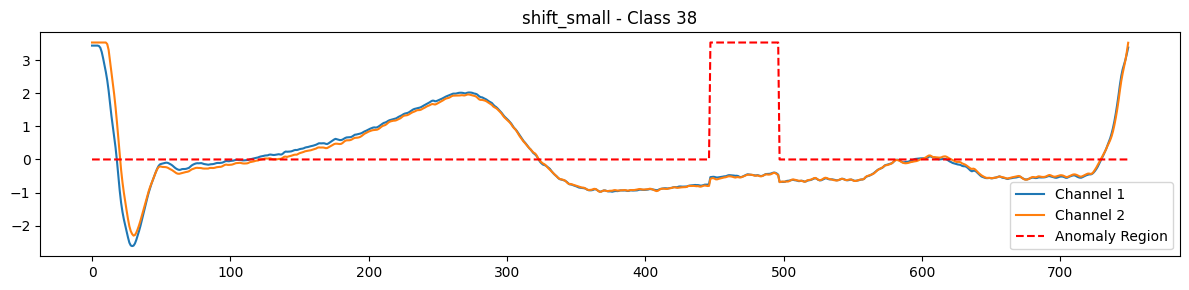

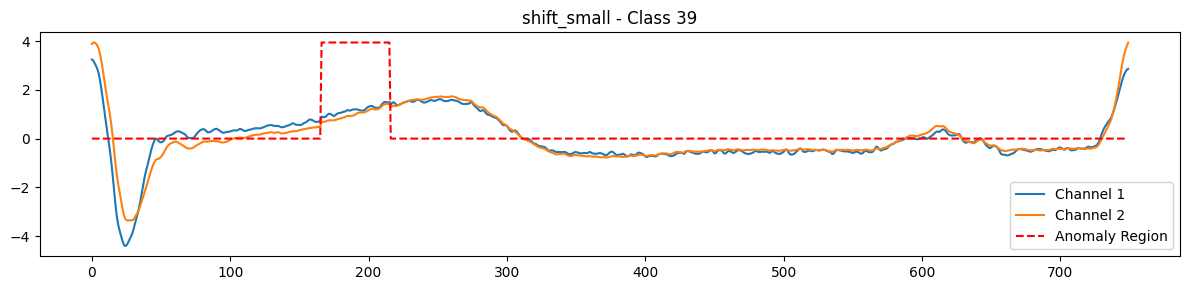

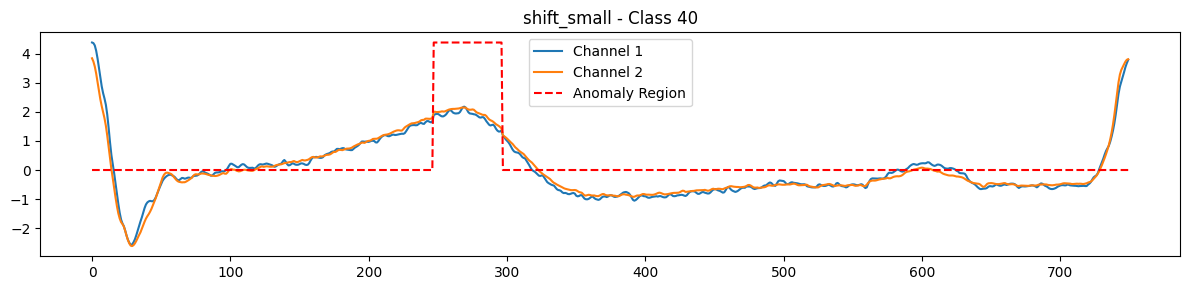

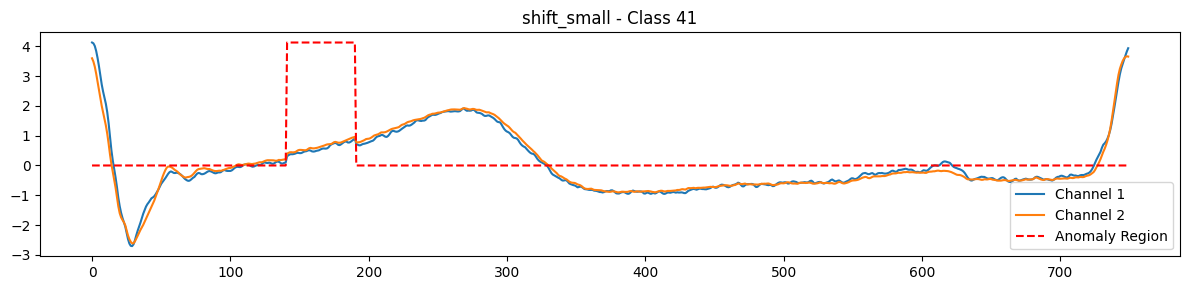

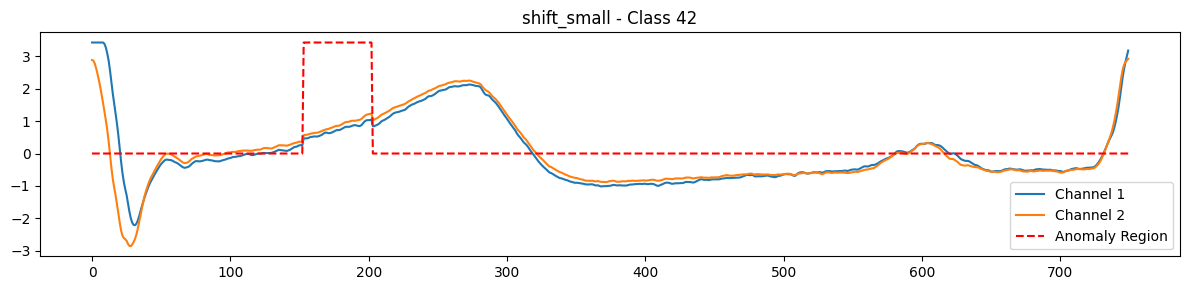

🔍 Condition: shift_medium


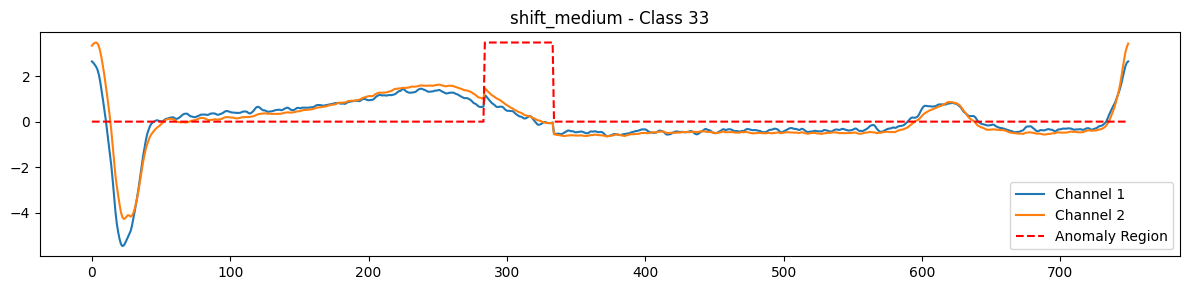

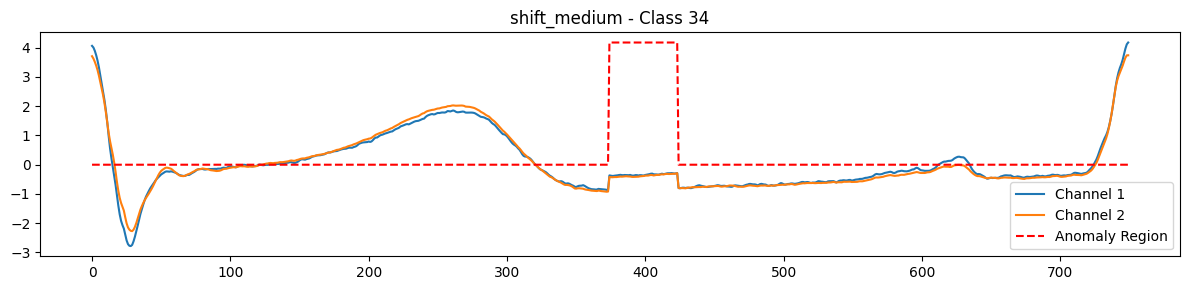

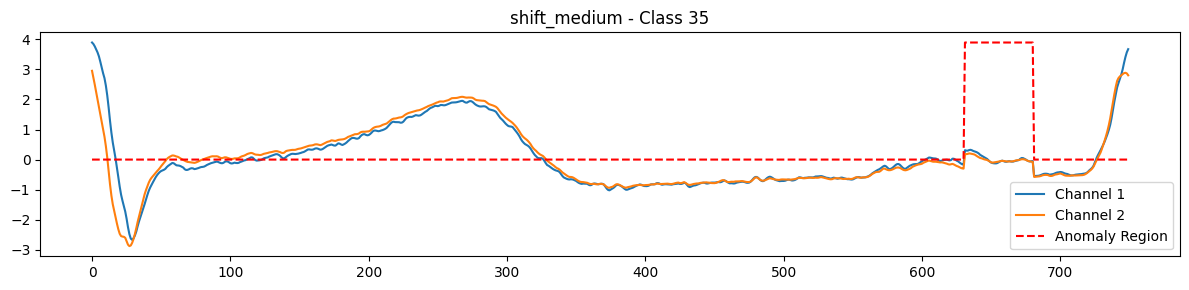

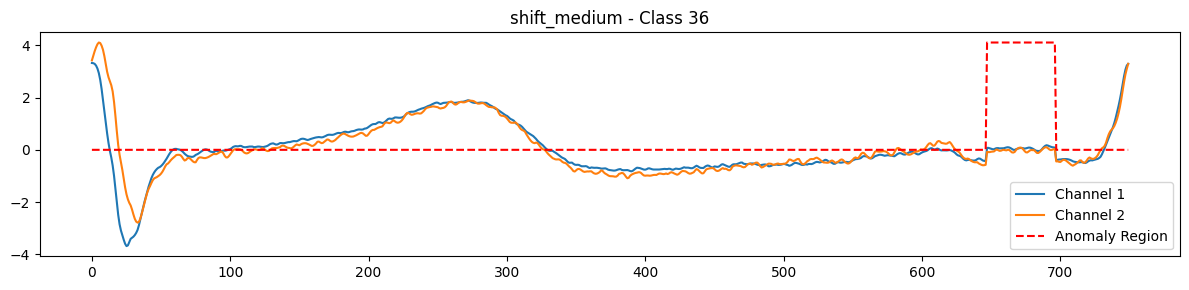

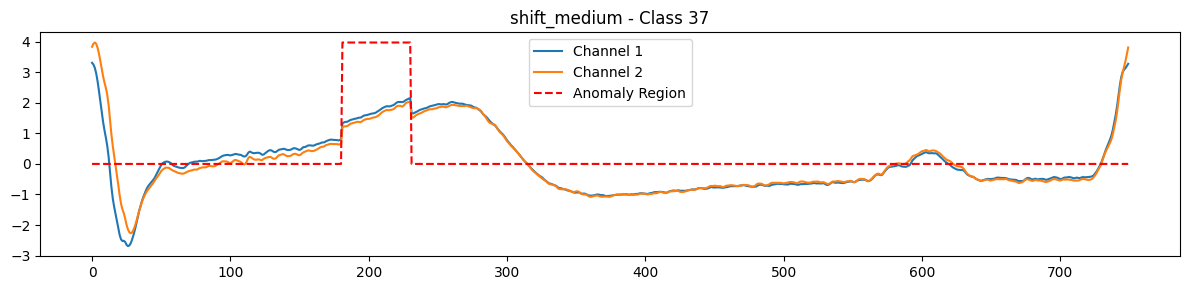

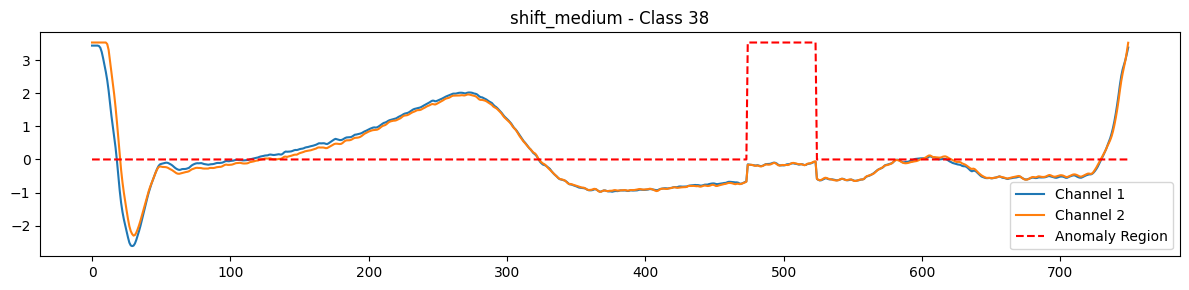

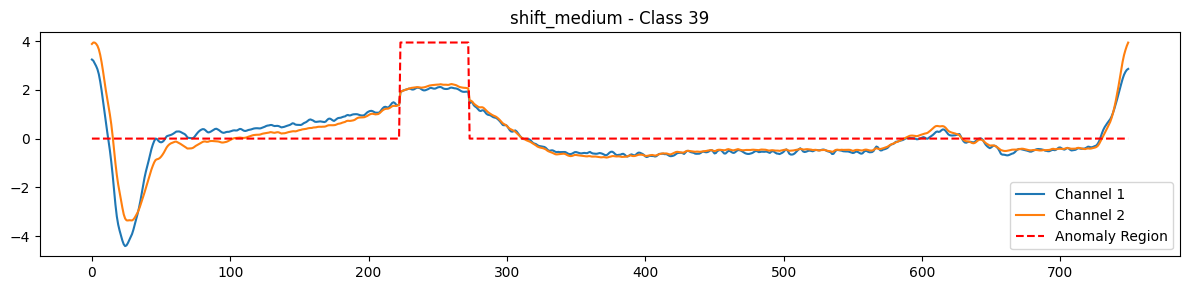

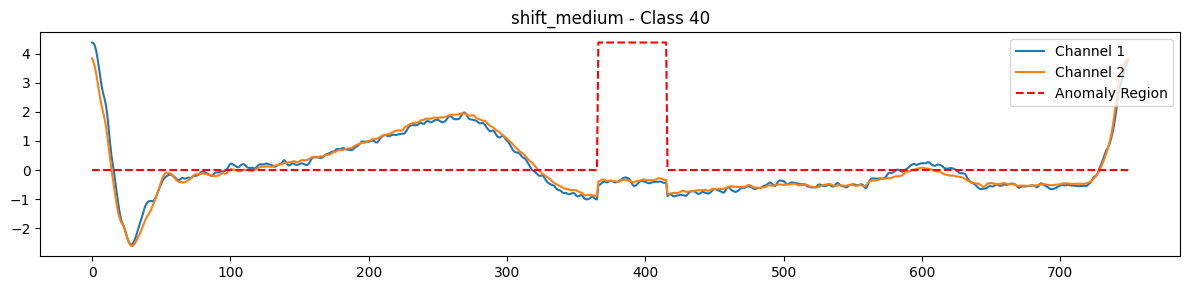

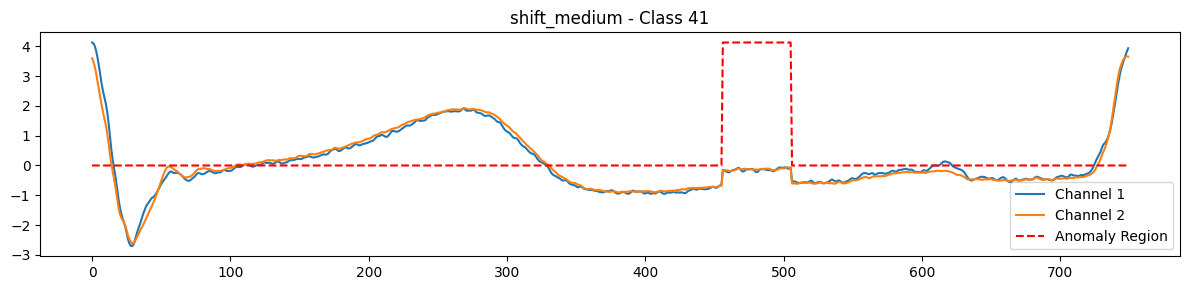

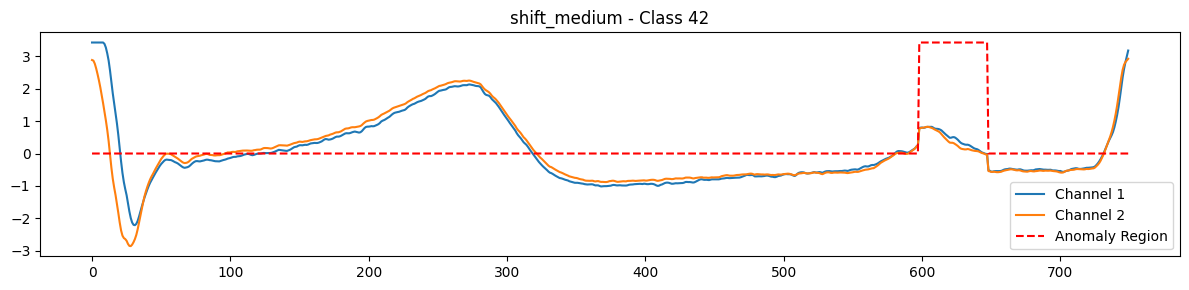

🔍 Condition: shift_large


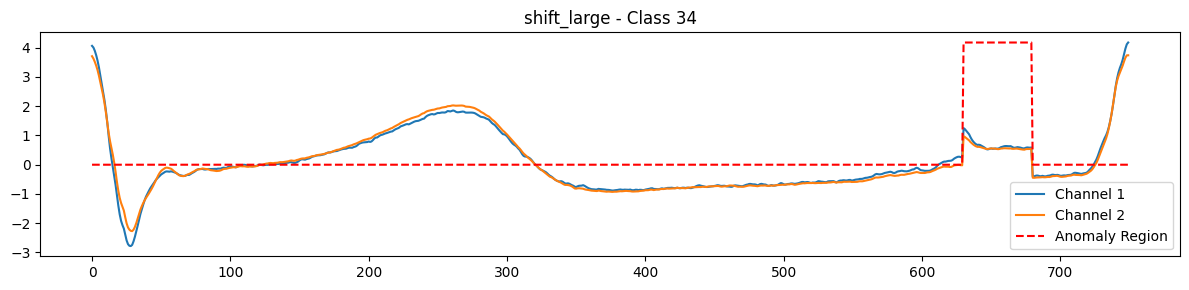

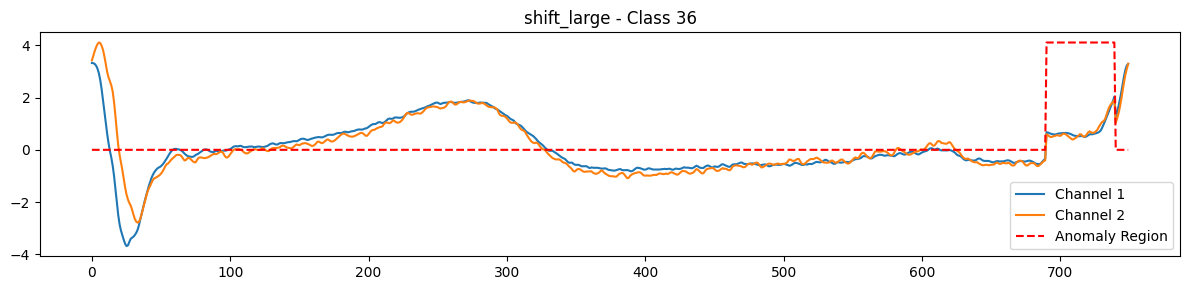

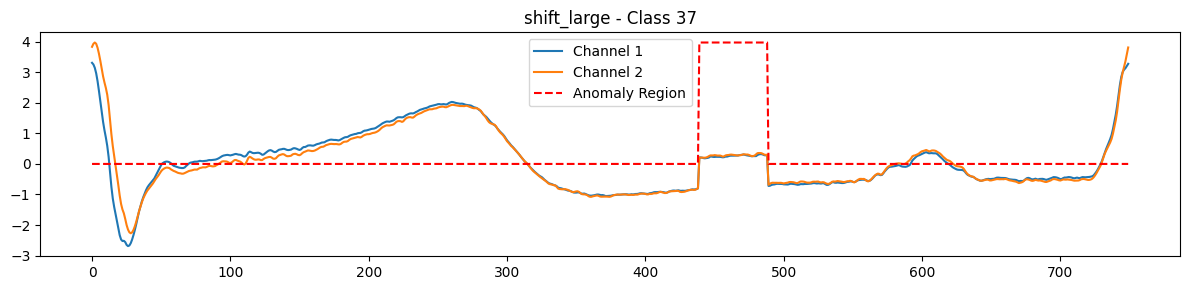

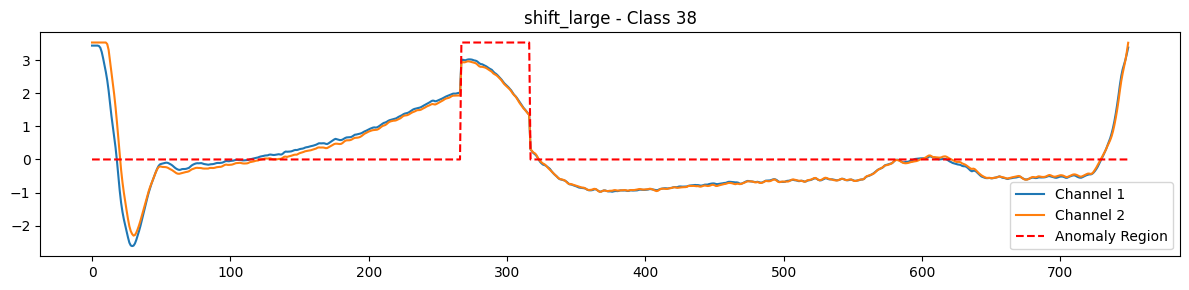

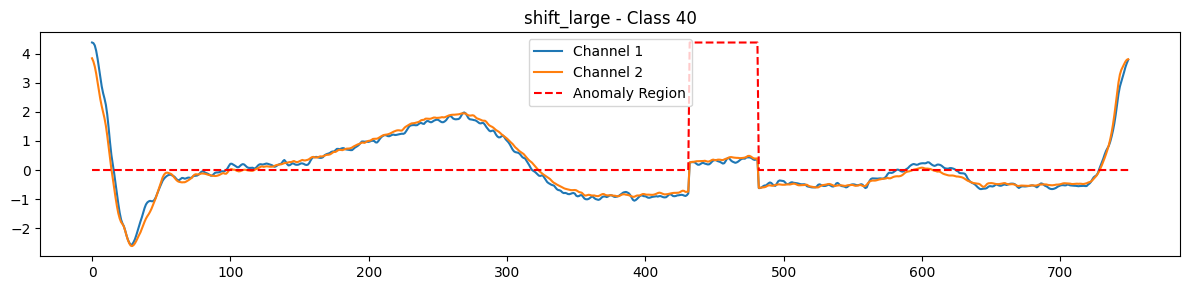

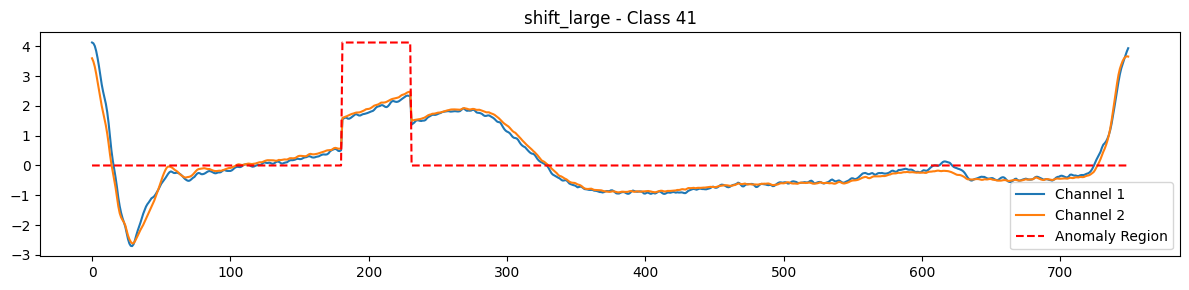

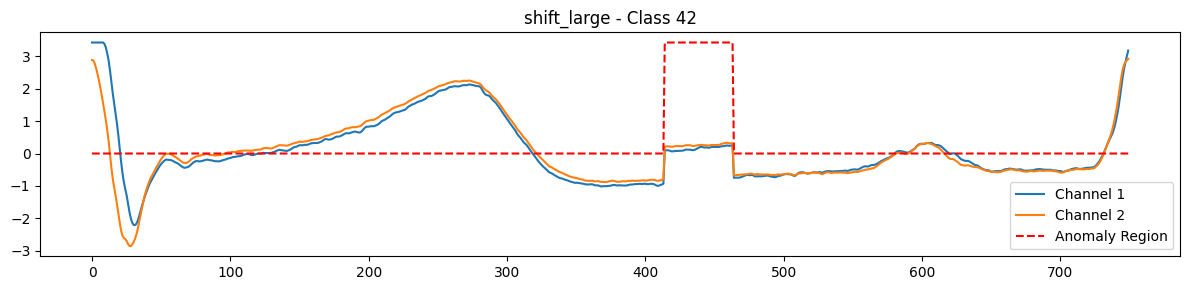

🔍 Condition: both_small


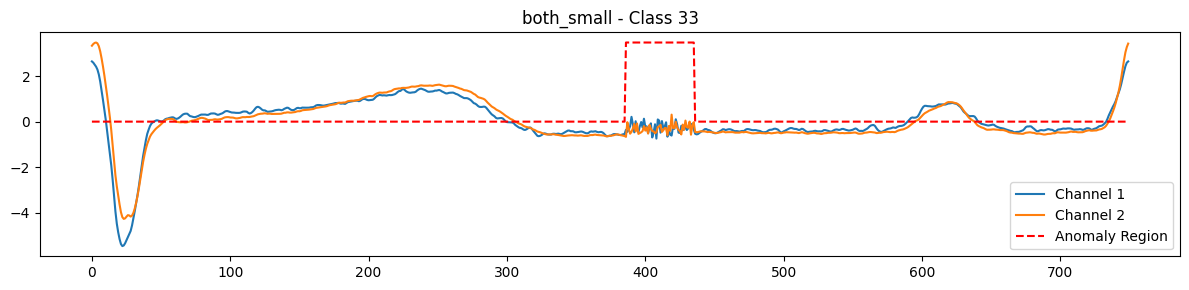

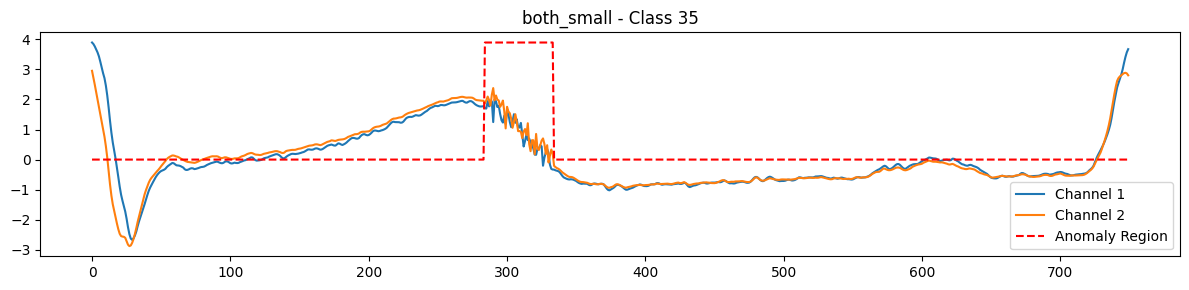

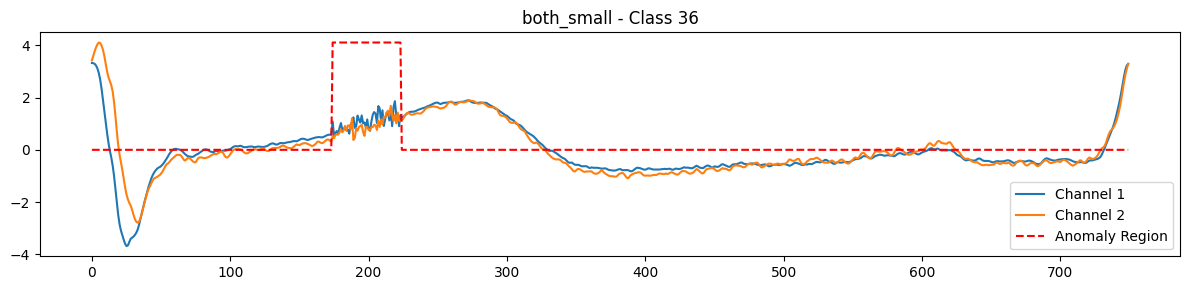

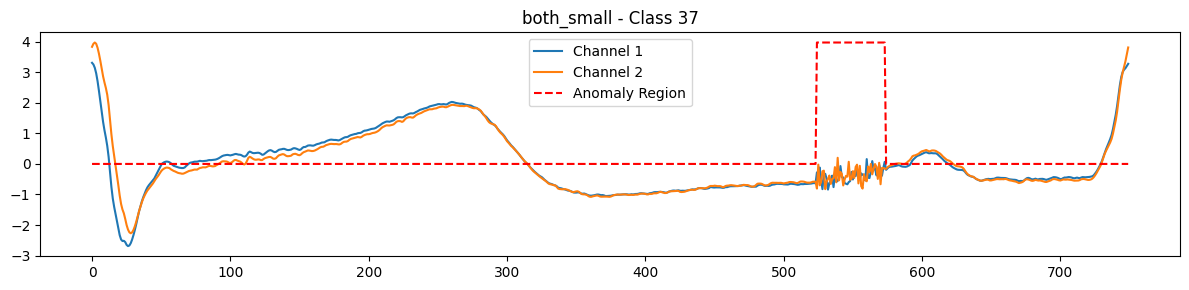

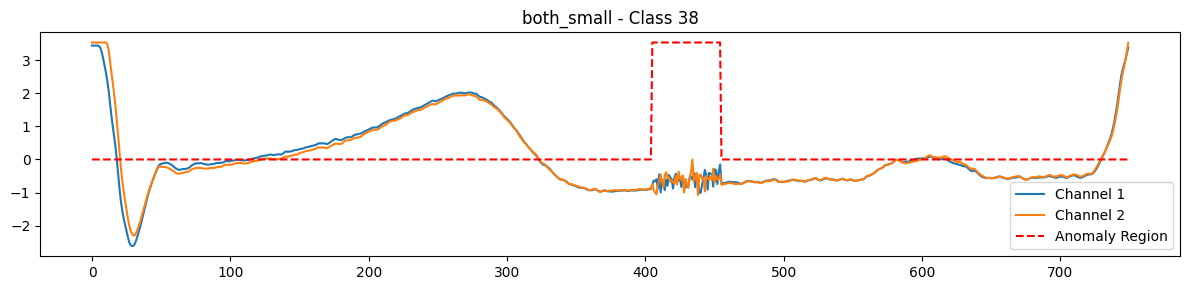

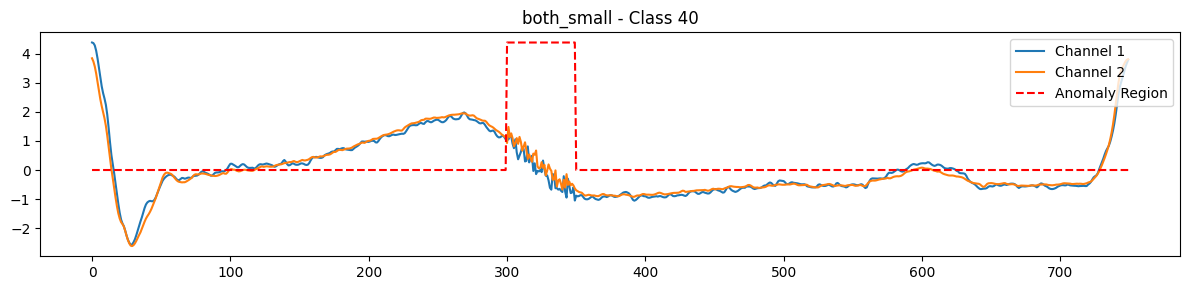

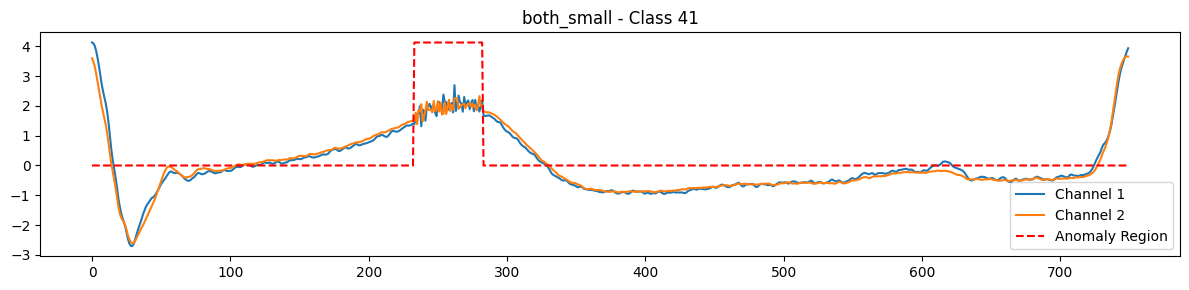

🔍 Condition: both_medium


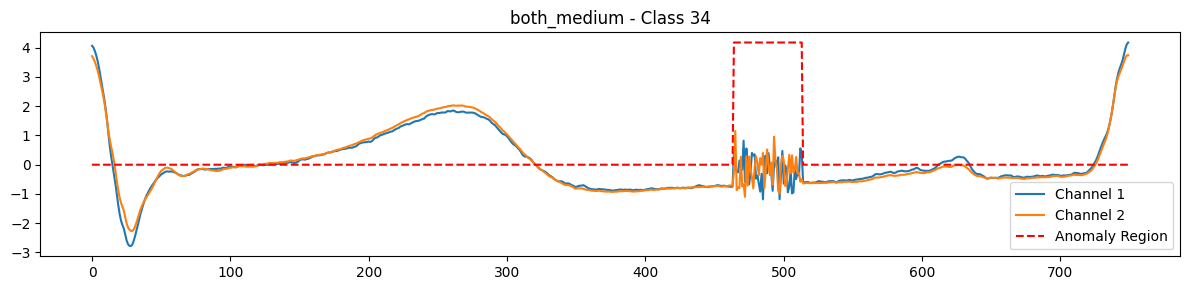

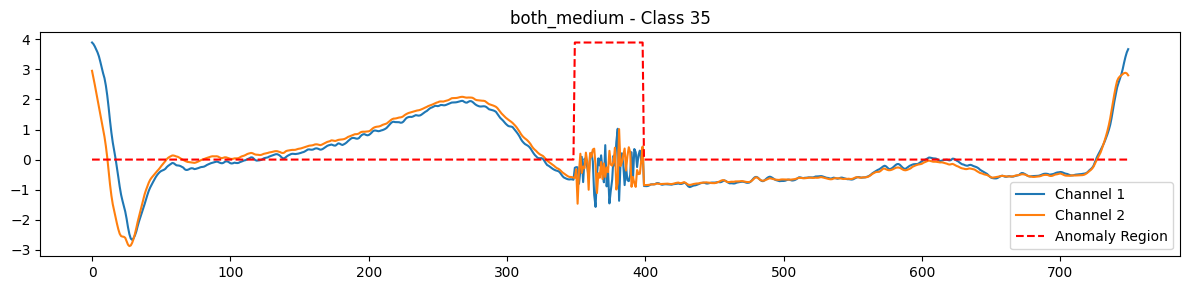

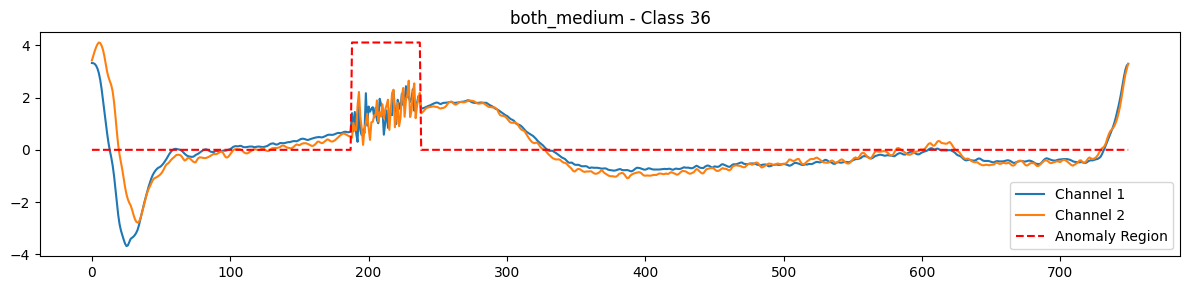

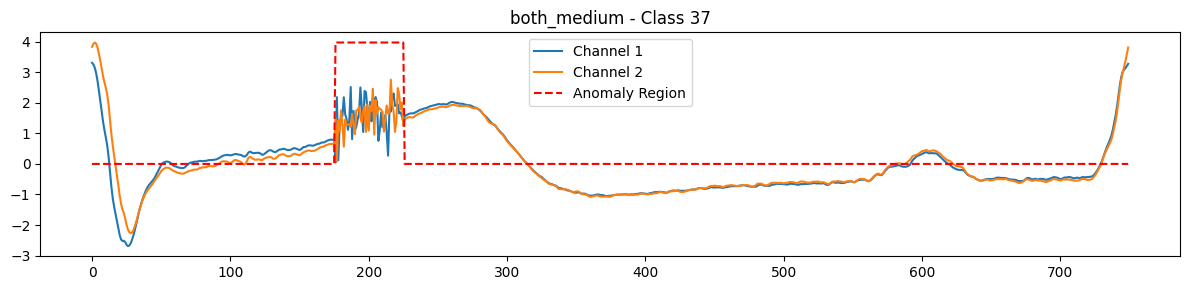

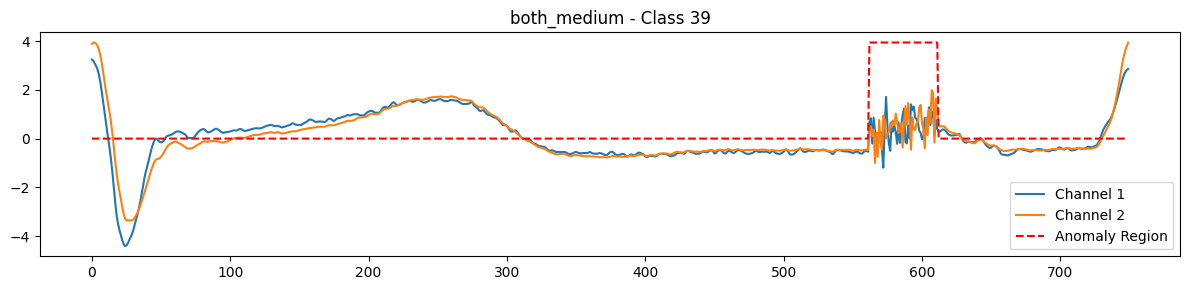

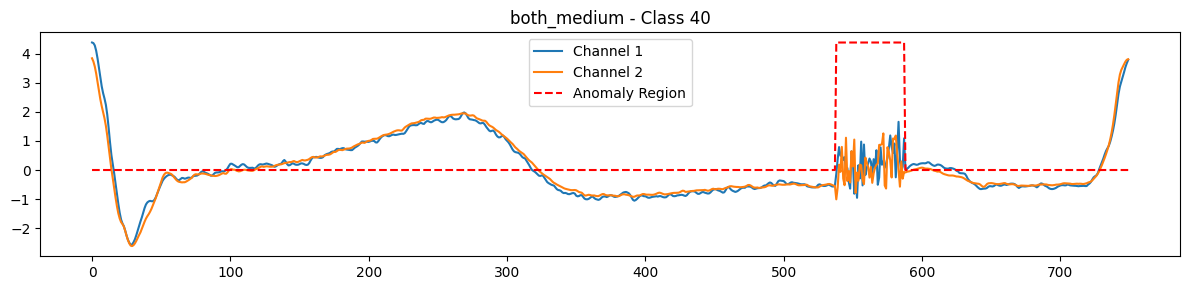

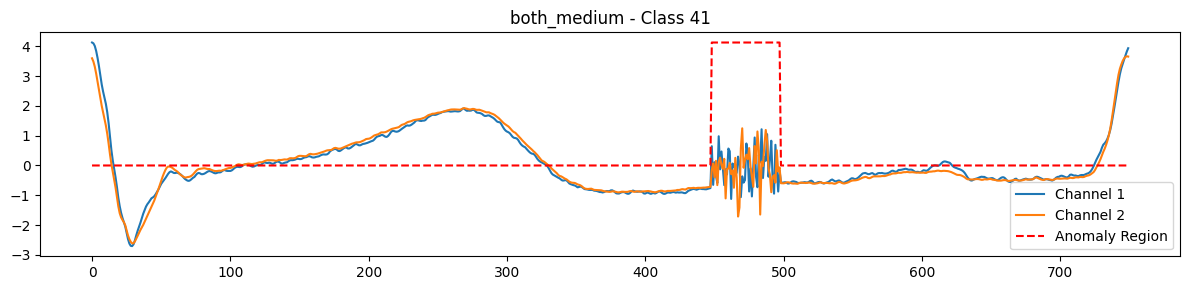

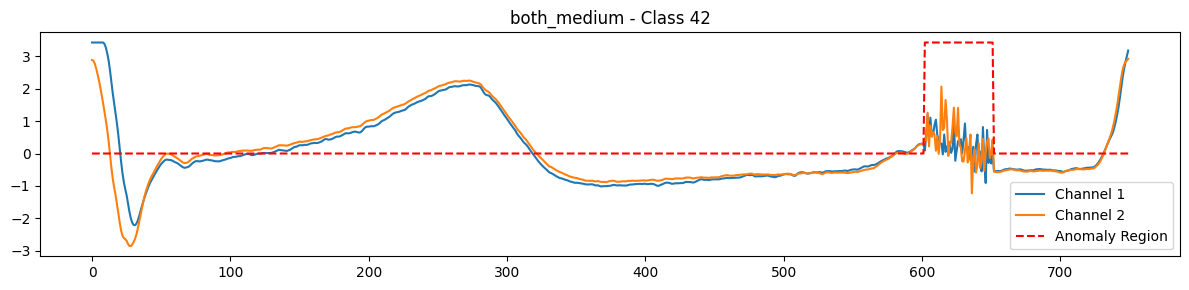

🔍 Condition: both_large


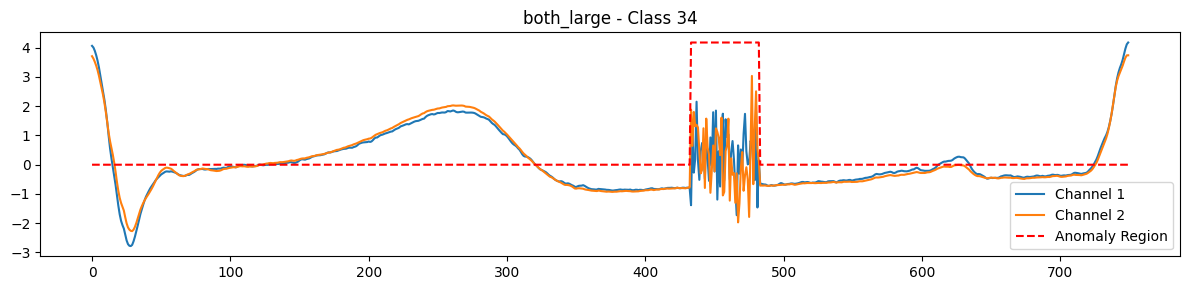

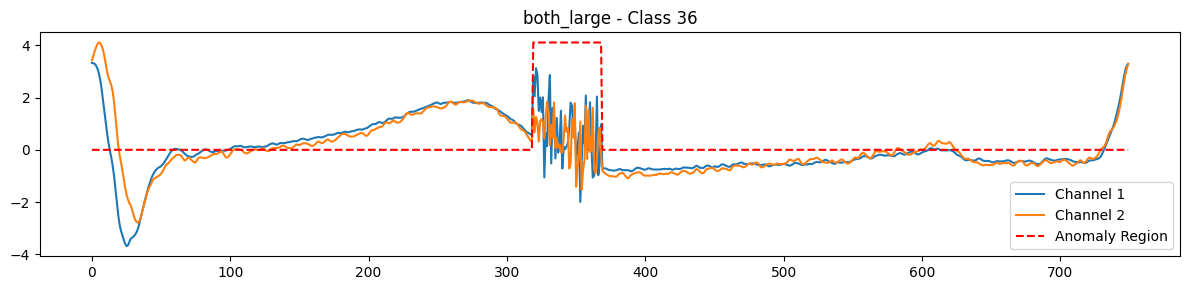

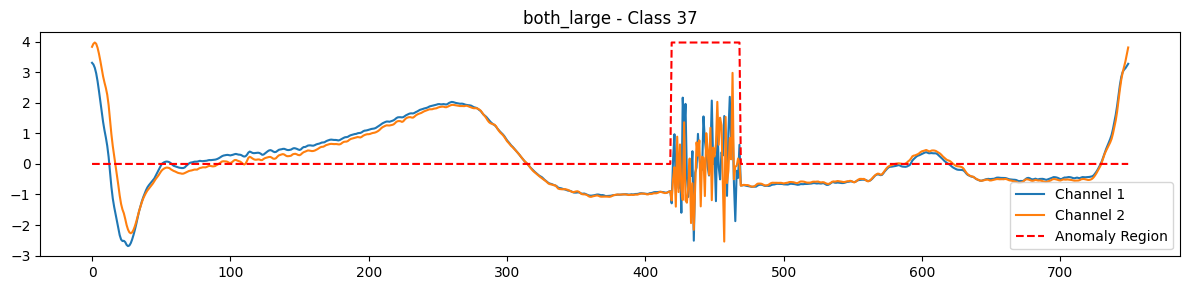

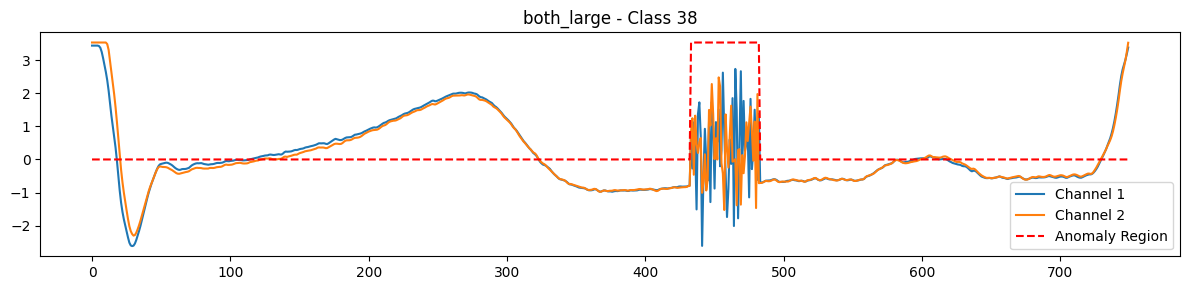

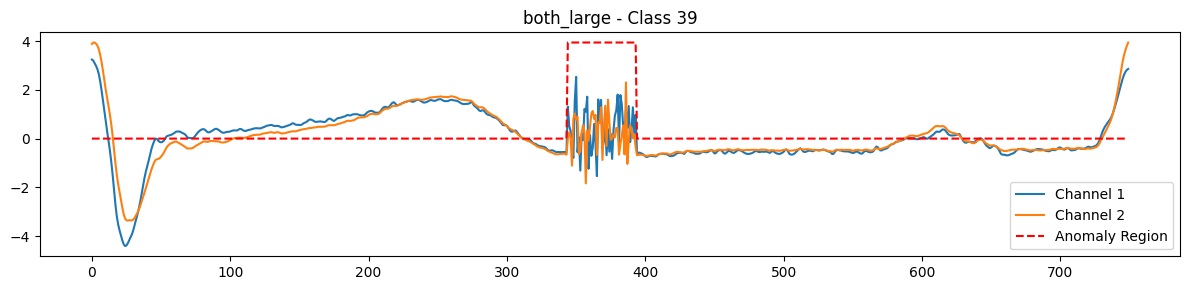

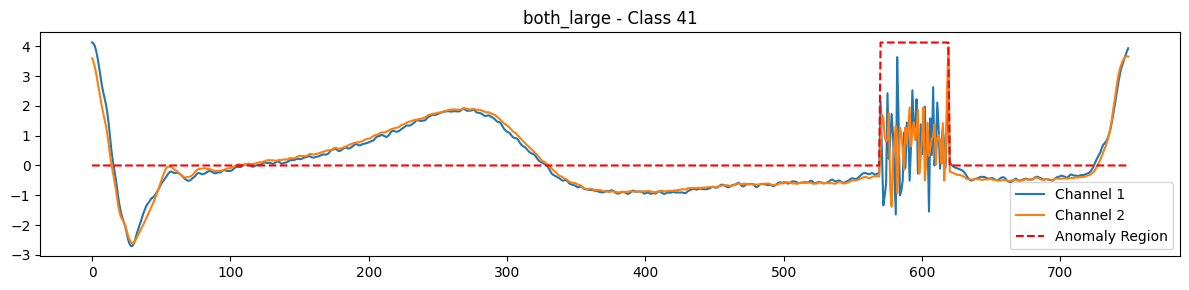

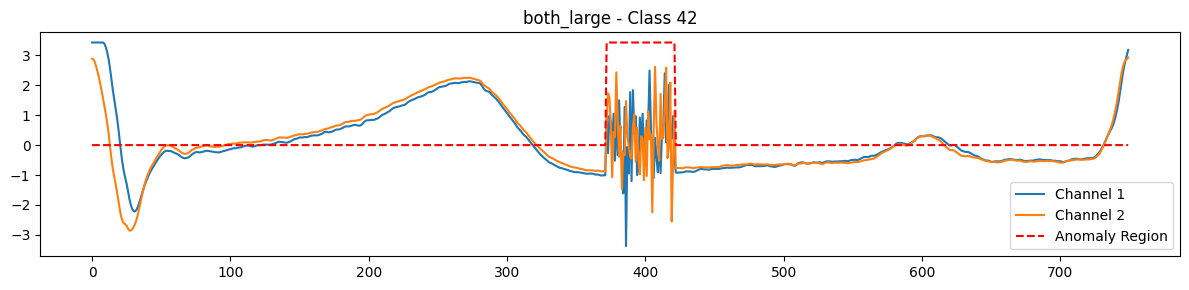

In [11]:
def visualize_anomaly_example(data, mask, label_array, class_id, title=""):
    # 해당 클래스 중 첫 번째 샘플 선택
    indices = np.where(label_array == class_id)[0]
    if len(indices) == 0:
        return  # 해당 클래스 없을 경우 건너뜀
    idx = indices[0]

    plt.figure(figsize=(12, 3))
    for c in range(2):
        plt.plot(data[idx, c], label=f'Channel {c+1}')
    plt.plot(mask[idx] * np.max(data[idx]), 'r--', label='Anomaly Region')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 모든 조건에 대해 클래스별 1개씩 시각화
for key in results:
    print(f"🔍 Condition: {key}")
    for class_id in sorted(set(test_labels)):  # 클래스 33~42
        visualize_anomaly_example(
            results[key]["data"],
            results[key]["anomaly_mask"],
            test_labels,
            class_id,
            title=f"{key} - Class {class_id}"
        )

In [ ]:
# anomaly 마스크 전체 저장용 리스트
all_anomaly_masks = []

# test 이상 조합 데이터 정리
augmented_test_data = []
augmented_test_labels = []
augmented_test_conditions = []

for key in results:
    data = results[key]["data"]           # (B, 2, 750)
    mask = results[key]["anomaly_mask"]   # (B, 750)

    for i in range(len(data)):
        label = test_labels[i]
        condition = key

        ch1 = data[i, 0]
        ch2 = data[i, 1]
        anomaly = mask[i]

        row = np.concatenate([ch1, ch2, anomaly])  # (750 + 750 + 750)
        augmented_test_data.append(row)
        augmented_test_labels.append(label)
        augmented_test_conditions.append(condition)
        
        all_anomaly_masks.append(anomaly)  # mask 저장
        
# test DataFrame 구성 및 저장
columns = [f"ch1_{i}" for i in range(750)] + [f"ch2_{i}" for i in range(750)] + [f"anomaly_{i}" for i in range(750)]
test_df = pd.DataFrame(augmented_test_data, columns=columns)
test_df.insert(0, "label", augmented_test_labels)
test_df.insert(1, "condition", augmented_test_conditions)

# train DataFrame 구성 및 저장
train_rows = [np.concatenate([train_data[i, 0], train_data[i, 1]]) for i in range(len(train_data))]
train_columns = [f"ch1_{i}" for i in range(750)] + [f"ch2_{i}" for i in range(750)]
train_df = pd.DataFrame(train_rows, columns=train_columns)
train_df.insert(0, "label", train_labels)

In [30]:
train_df

label     ch1_0     ch1_1     ch1_2     ch1_3     ch1_4     ch1_5  \
0        33  3.057708  2.988563  2.821472  2.639237  2.445601  2.159802   
1         9  3.551183  3.538439  3.496559  3.467801  3.425732  3.294089   
2        10  3.543798  3.492157  3.372021  3.203759  2.987730  2.720849   
3        21  3.395535  3.360977  3.277669  3.144162  2.939326  2.656123   
4         3  3.241202  3.205867  3.154977  3.128858  3.082867  2.970339   
...     ...       ...       ...       ...       ...       ...       ...   
3275     18  3.790829  3.691666  3.509867  3.278486  3.010378  2.712889   
3276     29  3.838080  3.835355  3.782401  3.686742  3.554113  3.387818   
3277     12  3.191759  3.180782  3.135725  3.045793  2.904169  2.701182   
3278     18  3.462029  3.368502  3.174639  2.920388  2.637429  2.342940   
3279      1  3.159234  3.150539  3.118747  3.057155  2.947649  2.765411   

         ch1_6     ch1_7     ch1_8  ...   ch2_740   ch2_741   ch2_742  \
0     1.760442  1.288552  0.779692  ...  0.876671  1.113409  1.381520   
1     3.069612  2.768019  2.384278  ...  0.802482  0.956400  1.148937   
2     2.415307  2.095017  1.819433  ...  1.712407  2.037029  2.349915   
3     2.305517  1.910022  1.507525  ...  1.482932  1.726928  2.017591   
4     2.765154  2.461359  2.069992  ...  0.881946  1.011842  1.174012   
...        ...       ...       ...  ...       ...       ...       ...   
3275  2.393363  2.055474  1.754312  ...  1.916959  2.244107  2.536834   
3276  3.180044  2.907473  2.614492  ...  2.236872  2.545989  2.818188   
3277  2.432373  2.130495  1.775533  ...  2.229856  2.571576  2.904734   
3278  2.034422  1.702486  1.375386  ...  1.733028  2.082954  2.436369   
3279  2.479916  2.090259  1.638196  ...  1.216480  1.323309  1.448754   

       ch2_743   ch2_744   ch2_745   ch2_746   ch2_747   ch2_748   ch2_749  
0     1.691820  2.049675  2.461128  2.913115  3.332460  3.621375  3.808486  
1     1.406610  1.719602  2.068995  2.449719  2.850918  3.185048  3.402737  
2     2.617250  2.806612  2.981521  3.174866  3.385539  3.590607  3.753423  
3     2.316327  2.594837  2.851955  3.080110  3.257878  3.373336  3.483975  
4     1.411700  1.713846  2.066235  2.433607  2.761396  3.026934  3.230218  
...        ...       ...       ...       ...       ...       ...       ...  
3275  2.779277  2.970837  3.149826  3.363534  3.628126  3.912173  4.143841  
3276  3.028644  3.177798  3.285670  3.378401  3.472561  3.568436  3.642560  
3277  3.153186  3.313946  3.407591  3.463455  3.502660  3.524065  3.493679  
3278  2.771862  3.049360  3.273419  3.477618  3.696343  3.931775  4.123443  
3279  1.605488  1.811444  2.088262  2.428632  2.787131  3.113269  3.356557  

[3280 rows x 1501 columns]

In [31]:
test_df

label    condition     ch1_0     ch1_1     ch1_2     ch1_3     ch1_4  \
0        41  noise_small  4.124322  4.096476  4.006952  3.838741  3.606711   
1        38  noise_small  3.438418  3.438418  3.438418  3.438418  3.438418   
2        39  noise_small  3.244242  3.197861  3.094352  2.982339  2.846862   
3        42  noise_small  3.429315  3.429315  3.429315  3.429315  3.429315   
4        41  noise_small  4.169738  4.075640  3.927018  3.689728  3.362903   
...     ...          ...       ...       ...       ...       ...       ...   
4360     41   both_large  3.947757  3.852564  3.696216  3.483623  3.227093   
4361     38   both_large  3.547417  3.547417  3.547417  3.524377  3.456669   
4362     33   both_large  2.811756  2.785619  2.740899  2.649148  2.534153   
4363     34   both_large  4.351534  4.291548  4.162796  3.990008  3.777252   
4364     36   both_large  3.313899  3.290730  3.254888  3.211324  3.150732   

         ch1_5     ch1_6     ch1_7  ...  anomaly_740  anomaly_741  \
0     3.331367  3.018474  2.719126  ...          0.0          0.0   
1     3.425776  3.373090  3.246711  ...          0.0          0.0   
2     2.641664  2.340986  1.974502  ...          0.0          0.0   
3     3.429315  3.429315  3.429315  ...          1.0          1.0   
4     3.006652  2.700205  2.447966  ...          0.0          0.0   
...        ...       ...       ...  ...          ...          ...   
4360  2.938860  2.640320  2.384349  ...          0.0          0.0   
4361  3.354944  3.228401  3.054300  ...          0.0          0.0   
4362  2.406671  2.211919  1.907953  ...          0.0          0.0   
4363  3.522926  3.233612  2.957013  ...          0.0          0.0   
4364  3.051733  2.885416  2.615114  ...          0.0          0.0   

      anomaly_742  anomaly_743  anomaly_744  anomaly_745  anomaly_746  \
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          0.0          0.0          0.0          0.0   
2             0.0          0.0          0.0          0.0          0.0   
3             1.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
4360          0.0          0.0          0.0          0.0          0.0   
4361          0.0          0.0          0.0          0.0          0.0   
4362          0.0          0.0          0.0          0.0          0.0   
4363          0.0          0.0          0.0          0.0          0.0   
4364          0.0          0.0          0.0          0.0          0.0   

      anomaly_747  anomaly_748  anomaly_749  
0             0.0          0.0          0.0  
1             0.0          0.0          0.0  
2             0.0          0.0          0.0  
3             0.0          0.0          0.0  
4             0.0          0.0          0.0  
...           ...          ...          ...  
4360          0.0          0.0          0.0  
4361          0.0          0.0          0.0  
4362          0.0          0.0          0.0  
4363          0.0          0.0          0.0  
4364          0.0          0.0          0.0  

[4365 rows x 2252 columns]

In [21]:
# 클래스 리스트 (오름차순)
print("✅ train 클래스 목록:", sorted(train_df["label"].unique()))
print("✅ train 클래스 수:", len(train_df["label"].unique()))

print("✅ test 클래스 목록:", sorted(test_df["label"].unique()))
print("✅ test 클래스 수:", len(test_df["label"].unique()))

✅ train 클래스 목록: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
✅ train 클래스 수: 42
✅ test 클래스 목록: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
✅ test 클래스 수: 10


In [32]:
print(" train 클래스별 샘플 수:")
print(train_df["label"].value_counts().sort_index())

 train 클래스별 샘플 수:
1     84
2     91
3     87
4     85
5     96
6     94
7     93
8     91
9     88
10    92
11    75
12    90
13    97
14    89
15    98
16    95
17    85
18    91
19    88
20    90
21    89
22    86
23    87
24    87
25    90
26    78
27    89
28    85
29    96
30    86
31    94
32    90
33    37
34    52
35    45
36    40
37    37
38    41
39    43
40    45
41    39
42    45
Name: label, dtype: int64


In [33]:
for class_id in sorted(set(test_labels)):
    count = np.sum(test_labels == class_id)
    print(f"Class {class_id}: 원본 샘플 {count}개 → 9가지 경우의 수 확장 후 {count * 9}개")

Class 33: 원본 샘플 48개 → 9가지 경우의 수 확장 후 432개
Class 34: 원본 샘플 42개 → 9가지 경우의 수 확장 후 378개
Class 35: 원본 샘플 49개 → 9가지 경우의 수 확장 후 441개
Class 36: 원본 샘플 51개 → 9가지 경우의 수 확장 후 459개
Class 37: 원본 샘플 50개 → 9가지 경우의 수 확장 후 450개
Class 38: 원본 샘플 50개 → 9가지 경우의 수 확장 후 450개
Class 39: 원본 샘플 47개 → 9가지 경우의 수 확장 후 423개
Class 40: 원본 샘플 46개 → 9가지 경우의 수 확장 후 414개
Class 41: 원본 샘플 54개 → 9가지 경우의 수 확장 후 486개
Class 42: 원본 샘플 48개 → 9가지 경우의 수 확장 후 432개


In [35]:
# 저장 경로
test_save_path = "/Users/jeongseohyeon/Desktop/AnomalyDiT-main/Dataset/ECG_Test_with_anomaly_noise_shift.csv"
train_save_path = "/Users/jeongseohyeon/Desktop/AnomalyDiT-main/Dataset/ECG_Train_new.csv"
point_label_save_path = "/Users/jeongseohyeon/Desktop/AnomalyDiT-main/Dataset/ECG_Anomaly_new_PointLabels.npy"

test_df.to_csv(test_save_path, index=False)
train_df.to_csv(train_save_path, index=False)
np.save(point_label_save_path, np.array(all_anomaly_masks))  # (N, 750) 저장

# 정보 확인
print("저장 완료")
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)
print("anomaly_point_labels shape:", np.array(all_anomaly_masks).shape)
print("총 학습 샘플 수:", len(train_df))
print("총 테스트 샘플 수:", len(test_df))

저장 완료
train_df shape: (3280, 1501)
test_df shape: (4365, 2252)
anomaly_point_labels shape: (4365, 750)
총 학습 샘플 수: 3280
총 테스트 샘플 수: 4365
